In [ ]:
# #gpu
# !pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv torch_geometric -f https://data.pyg.org/whl/torch-1.13.0+cu116.html

In [ ]:
# #cpu
# !pip install pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.13.0+cpu.html

In [ ]:
!pip install wandb torch_geometric wandb

In [ ]:
import sys
import wandb
import os

"""
file_path_in_run username/project/run_id
"""

def restore_file_wandb(file_path:str, run_name:str):
    if not os.path.exists("/".join(file_path.split("/")[:-1])):
        os.makedirs("/".join(file_path.split("/")[:-1]))
    wandb.restore(file_path, run_path=run_name)

In [ ]:
restore_file_wandb("graph_trainset_sota_financial_1st_year/processed/data.pt", "mirette-gp/dataset_save/rcnp6b4r")
restore_file_wandb("graph_trainset_sota_financial_1st_year/processed/pre_filter.pt", "mirette-gp/dataset_save/rcnp6b4r")
restore_file_wandb("graph_trainset_sota_financial_1st_year/processed/pre_transform.pt", "mirette-gp/dataset_save/rcnp6b4r")
restore_file_wandb("graph_testset_sota_financial_1st_year/processed/data.pt", "mirette-gp/dataset_save/rcnp6b4r")
restore_file_wandb("graph_testset_sota_financial_1st_year/processed/pre_filter.pt", "mirette-gp/dataset_save/rcnp6b4r")
restore_file_wandb("graph_testset_sota_financial_1st_year/processed/pre_transform.pt", "mirette-gp/dataset_save/rcnp6b4r")

In [ ]:
from google.colab import drive

drive.mount("drive")

Mounted at drive


In [ ]:
import torch
torch.__version__

'2.0.0+cu118'

In [ ]:
from torch_geometric.utils import (
    add_self_loops,
    negative_sampling,
    remove_self_loops ,
)
import torch.nn.functional as F
from sklearn.metrics import accuracy_score,roc_auc_score,average_precision_score
from sklearn.metrics import precision_score
import warnings
warnings.filterwarnings("ignore")
import time


import numpy as np
import scipy.sparse as sp
from torch import nn
import pandas as pd
# import networkx as nx
from typing import List , Dict,Tuple
from torch_geometric.nn import SAGEConv, to_hetero
import torch

import matplotlib.pyplot as plt
import torch_geometric.nn as  gnn
from torch_geometric.data  import Data
from torch_geometric.data import HeteroData

from torch.nn import functional as F
import torch
from torch.optim.adamw import AdamW
import time
from argparse import ArgumentParser
import argparse
import wandb
import numpy as np
import random
import os
import datetime
from tqdm import tqdm
generator = torch.manual_seed(232)
np.random.seed(232)
torch.cuda.manual_seed(232)
torch.cuda.manual_seed_all(232)
random.seed(232)


In [ ]:

# """
# https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_dataset.html
# """
from torch_geometric.data  import InMemoryDataset
class WeekGraphs(InMemoryDataset):
    def __init__(self, root, transform=None):
        super().__init__(root, transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def processed_file_names(self):
        return 'data.pt'

    def process(self):
        torch.save(self.collate(self.data_list), self.processed_paths[0])
# dataset = WeekGraphs("/content/drive/MyDrive/Stock Market Prediction Graduation Project/graph_dataset", [])

In [ ]:
train = WeekGraphs("graph_trainset_sota_financial_1st_year")
test = WeekGraphs("graph_testset_sota_financial_1st_year")

In [ ]:
len(train), len(test)

(1025, 257)

In [ ]:
from torch_geometric.loader import DataLoader


train_loader = DataLoader(train, batch_size=8, shuffle=True)
test_loader = DataLoader(test, batch_size=8, shuffle=False)

In [ ]:


class LSTM(nn.Module):
    def __init__(self, input_size=1, num_layers=2,hidden_size=64, output_size=64, num_steps =15 ):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        # self.lstm2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, output_size)
        self.batch_norm1 = nn.BatchNorm1d(num_steps)

    def forward(self, x):
        # h0 = torch.zeros(2, x.size(0), 100).to(device) # num_layers * num_directions, batch_size, hidden_size
        # c0 = torch.zeros(2, x.size(0), 100).to(device)
        x = self.batch_norm1(x)
        out, _ = self.lstm1(x)
        # out, _ = self.lstm2(out)
        out = F.gelu(self.fc1(out[:, -1, :]))
        return out



In [ ]:
class GConv(nn.Module):

    def __init__(self, emb_dim:int=64, num_layers:int=2, encode:bool=True, concat_out:bool=False, device='cpu', dropout=0.2):

        super(GConv,self).__init__()
        self.num_layers = num_layers
        self.gconv_layers = []
        self.norm_layers = []
        self.encode = encode
        for _ in range(num_layers):
            self.gconv_layers.append(gnn.GATConv(emb_dim, emb_dim, dropout=dropout, project=True, add_self_loops = False).to(device)) # project=True ()
            if self.encode:
                self.norm_layers.append(nn.LayerNorm(emb_dim).to(device))
        self.gconv_layers = nn.ModuleList(self.gconv_layers)
        self.norm_layers = nn.ModuleList(self.norm_layers)

        self.concat_out = concat_out

    def forward(self, x, edge_index):

        outs = []
        if self.encode:
            outs.append(self.norm_layers[0](self.gconv_layers[0](x, edge_index)))
        else:
            outs.append(self.gconv_layers[0](x, edge_index))
        for i in range(1,self.num_layers):
            if self.encode:
                outs.append(self.norm_layers[i](self.gconv_layers[i](outs[-1], edge_index)))
            else:
                outs.append(self.gconv_layers[i](outs[-1], edge_index))
        if self.concat_out:
            return torch.cat(outs, dim = -1)

        return outs[-1]



class NeuroStock(nn.Module):

  def __init__(self,
               num_timeseries_features=1,
               n_companies=325,
               company_emb_size=32,
               node_emb_size=64,
               article_emb_size=768,
               n_industries=14,
               n_gnn_layers=3,
               graph_metadata:Tuple=None):
    super(NeuroStock, self).__init__()
    """
    company node representation will be a concatenation of its embedding and the output of the timeseries model (in this case it's an LSTM)
    """
    self.num_timeseries_features = num_timeseries_features
    self.n_companies = n_companies
    self.company_emb_size = company_emb_size
    self.node_emb_size = node_emb_size
    self.article_emb_size = article_emb_size
    self.n_industries = n_industries
    self.n_gnn_layers = n_gnn_layers
    self.lstm = LSTM(input_size=num_timeseries_features,  hidden_size=company_emb_size, output_size=company_emb_size).to(torch.float)

    if graph_metadata is None:
      raise("You need to pass HeteroData.metadata()")
    self.company_embedding = nn.Embedding(n_companies, company_emb_size).to(torch.float)
    self.industry_embedding = nn.Embedding(n_industries, node_emb_size).to(torch.float)
    self.project_article = nn.Linear(article_emb_size, node_emb_size).to(torch.float)

    # to_hetero transforms normal gnn aggregation layer to a heterogeneous aggregation layer
    # https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.to_hetero_transformer.to_hetero
    self.g_conv = gnn.to_hetero(GConv(emb_dim=node_emb_size, num_layers=n_gnn_layers), graph_metadata).to(torch.float)
    self.classifier = nn.Linear(node_emb_size, 1).to(torch.float)

  def forward(self, hetero_x:HeteroData):
    hetero_x["article"].x = self.project_article(hetero_x["article"].x)
    companies = self.company_embedding(hetero_x["company"].x)
    # print(hetero_x["company_timeseries"][:,:, -2:-1].to(torch.double).shape, hetero_x["company_timeseries"][:,:, -2:-1].to(torch.float).dtype)
    # company_timeseries is of shape (n_companies*batch_size, n_days, n_features)  the features are "open", "high", "low", "close", "volume"
    companies_timeseries = self.lstm(hetero_x["company_timeseries"][:,:, -2:-1].to(torch.float))
    hetero_x["company"].x = torch.cat((companies_timeseries, companies), dim=-1)  #companies are in shape (n_companies*batch_size, node_emb_size)
    hetero_x["industry"].x = self.industry_embedding(hetero_x["industry"].x)
    graph = self.g_conv(hetero_x.x_dict, hetero_x.edge_index_dict)
    out = F.sigmoid(self.classifier(graph["company"]))
    return out

  def compute_loss(self, out, target):
    loss = F.binary_cross_entropy(out.reshape(-1), target.float())
    return loss


In [ ]:
batch

HeteroDataBatch(
  target=[2600],
  missing_prices=[2600],
  info_exists=[2600],
  company_timeseries=[2600, 15, 5],
  date=[8],
  company={
    x=[2600],
    batch=[2600],
    ptr=[9]
  },
  article={
    x=[2701, 32],
    batch=[2701],
    ptr=[9]
  },
  industry={
    x=[104],
    batch=[104],
    ptr=[9]
  },
  (article, main_company, company)={ edge_index=[2, 2701] },
  (article, mentioned, company)={ edge_index=[2, 5087] },
  (article, in_industry, industry)={ edge_index=[2, 2701] },
  (company, mentioned_in, article)={ edge_index=[2, 5087] },
  (company, in_industry, industry)={ edge_index=[2, 2600] },
  (industry, has_company, company)={ edge_index=[2, 2600] }
)

In [ ]:
import wandb

from tqdm import tqdm
wandb.init(
        project="test_gnn",
        name="1st_year_train",
        mode="online")

n_epochs = 50
# warmup_steps=

neurostock = NeuroStock(node_emb_size=32, company_emb_size=16, graph_metadata=train[0].metadata())
neurostock.to('cuda')
device = next(neurostock.parameters()).device
optimizer =  torch.optim.AdamW(neurostock.parameters(), lr=0.001)
# lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1,  total_iters=warmup_steps)
for e in tqdm(range(n_epochs)):
    train_losses= []
    neurostock.train()
    train_outs = []
    train_targets = []
    for batch  in train_loader:
        # with torch.autocast(device_type="cuda", dtype=torch.float16):
        batch = batch.to(device)
        out = neurostock(batch)
        train_outs.append(out.cpu().detach().reshape(-1))
        train_targets.append(batch["target"].cpu().detach().reshape(-1))
        loss = neurostock.compute_loss(out, batch["target"])
        optimizer.zero_grad()
        train_losses.append(loss.item())
        loss.backward()
        optimizer.step()
        # lr_scheduler.step()

    neurostock.eval()
    valid_losses = []
    # continue
    valid_outs = []
    valid_targets = []
    with torch.no_grad():
        for batch  in test_loader:

          batch = batch.to(device)
          out = neurostock(batch)
          valid_outs.append(out.reshape(-1).cpu().detach())
          valid_targets.append(batch["target"].reshape(-1).cpu().detach())
          loss = neurostock.compute_loss(out, batch["target"])
          valid_losses.append(loss.item())

    valid_outs = torch.cat(valid_outs).numpy()
    valid_targets = torch.cat(valid_targets).numpy()
    valid_acc = ((valid_outs >= 0.5) == valid_targets).mean()
    train_outs = torch.cat(train_outs).numpy()
    train_targets = torch.cat(train_targets).numpy()
    train_acc = ((train_outs >= 0.5) == train_targets).mean()
    wandb.log({
          "train_loss" : np.mean(train_losses),
          "valid_loss" : np.mean(valid_losses),
          "valid_acc" : valid_acc,
          "train_acc" : train_acc
    })
wandb.finish()


100%|██████████| 50/50 [01:22<00:00,  1.65s/it]


train_acc,▁▅▄▁▄▅▃▆▆▄▄▄▆▆▆▇▆▅▅▇▇▅█▇▇▇▇█▆▇▆▆▇▇█▇▇█▆▇
train_loss,█▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
valid_acc,▁▇▄▃▇▂▃▃▁▄█▂▂▃▃▄▂▃▂▄▂▂▃▇▂▃▃▅▄▂▄▃▂▄▄▃▂▄▂▆
valid_loss,█▁▃▃▂▄▃▃▅▃▁▃▄▄▅▃▇▃▅▅▆▄▅▁▅▆▄▃▃▅▄▅█▄▅▄▆▅▆▃
train_acc,0.52409
train_loss,0.69056
valid_acc,0.50564
valid_loss,0.69561


In [ ]:
!wget "https://doc-0c-1o-docs.googleusercontent.com/docs/securesc/canqtt7b9jpk8a9r3ucjk6vphoout6s7/rc2pqadrpd3f3sp9uoi49uj611s7hihl/1682709225000/03388427518829240458/13203297343859703330/1XrHQHdLjb762V82g-mfA_TGDtmOOL8tl?e=download&ax=ALy03A5_4dhmoFRCxDyUUY3cZVzftU6DpcgrrIfY_-XqSCkedAcgnNUCCiMY_A04dIWQVfGcpbG16ZXCtb9dC4zAho3fSw6u2IpQDpW_EGA7W82tnPt7aKiQb64F1TPJnVQovKoWhL0YCYxqiMY7s21u3ICfEyATveNMPRqVgybq8Z9IT0NrVitdyH1KpOKETqv67C-ctj6o0UziyipbCM4NPbobg345WJ3evXhOdQ8vt2W0JGyE_rzf9ObQnlLPATsYE21qbQYdYVAXmEWtRSI4LIU_7MVhvVfl6M79IMOLvjTpHY-882jfD4fm8e_3bwoVdI6EzZdbjtRLcv3qQGzpnh16fTLrGHuvYwLDDDwZGH7cK0wGUbwlrB2VBtniMvTJa3VBljgVgaztC8C8teVYeE9Q4bq4-oZP48esUd5MS3XB8sEYFZSaETXEHbIeArvh7t70u339TjeazYCOIlfOq-MwP8BIIOhOg_jmBh_LRTxUsnbUmiB8_sM7RJEWpi2-0yVChjM-ARO-4dVUwvGpn8VtpMRKeLEjYm0rlY1WVOSB13R8FRAntkLdP5cbQqGWIhMviMdWSMNGHQoVpCWaaOKpDxQaThreQOWilUJ5CgQHY6XY_DfG3613pqFVstEv8MNpDh8ZfiFxs3PDneUm4F5hr9iY6MdX_xRn6G5z2Z6ZC-N3kd9IF-R0Ee-bGSZ5exkajaEMtudsXyuBxHwK-wv-DehElrJfUwXUc5yEm2HdD6wscFcQ93kSPkEeY-Nt3P6qdj4N0g_fkcypu4II3QJ1Xj41gRQuu5niJObjYeve0w4LHq-YHoQCwC7tpk4Kf3_cwJkHSn0cfTxH6cK14uX9uIce7X6_K10-M1Be7SyomGvoh4G_mYU3q8iwFCB59Z5rpXYqWVRfZW3lTqBlr_AlGSC5BZKlShlxEmDxTUu5ceg_nFw0kpab4G2Jg4RkQLaDnFvZ1qq1mUfPxovbKcuBPTCvjfhbvuo&uuid=0cf9e020-3601-4e7b-8aa2-961e3545d209&authuser=0&nonce=5uf8am0i80mag&user=13203297343859703330&hash=3t1akfpmqh5131u7vu4rnus7bjggdavj" -O reuters_8.5M_titles.tar.bz2

--2023-04-28 19:47:04--  https://doc-0c-1o-docs.googleusercontent.com/docs/securesc/canqtt7b9jpk8a9r3ucjk6vphoout6s7/rc2pqadrpd3f3sp9uoi49uj611s7hihl/1682709225000/03388427518829240458/13203297343859703330/1XrHQHdLjb762V82g-mfA_TGDtmOOL8tl?e=download&ax=ALy03A5_4dhmoFRCxDyUUY3cZVzftU6DpcgrrIfY_-XqSCkedAcgnNUCCiMY_A04dIWQVfGcpbG16ZXCtb9dC4zAho3fSw6u2IpQDpW_EGA7W82tnPt7aKiQb64F1TPJnVQovKoWhL0YCYxqiMY7s21u3ICfEyATveNMPRqVgybq8Z9IT0NrVitdyH1KpOKETqv67C-ctj6o0UziyipbCM4NPbobg345WJ3evXhOdQ8vt2W0JGyE_rzf9ObQnlLPATsYE21qbQYdYVAXmEWtRSI4LIU_7MVhvVfl6M79IMOLvjTpHY-882jfD4fm8e_3bwoVdI6EzZdbjtRLcv3qQGzpnh16fTLrGHuvYwLDDDwZGH7cK0wGUbwlrB2VBtniMvTJa3VBljgVgaztC8C8teVYeE9Q4bq4-oZP48esUd5MS3XB8sEYFZSaETXEHbIeArvh7t70u339TjeazYCOIlfOq-MwP8BIIOhOg_jmBh_LRTxUsnbUmiB8_sM7RJEWpi2-0yVChjM-ARO-4dVUwvGpn8VtpMRKeLEjYm0rlY1WVOSB13R8FRAntkLdP5cbQqGWIhMviMdWSMNGHQoVpCWaaOKpDxQaThreQOWilUJ5CgQHY6XY_DfG3613pqFVstEv8MNpDh8ZfiFxs3PDneUm4F5hr9iY6MdX_xRn6G5z2Z6ZC-N3kd9IF-R0Ee-bGSZ5exkajaEMtudsXyuBxHwK-wv-DehElrJfUwXUc5

In [ ]:
neurostock.eval()
valid_losses = []
# continue
valid_outs = []
valid_targets = []
with torch.no_grad():
    for batch  in test_loader:

      batch = batch.to(device)
      out = neurostock(batch)
      outs = torch.cat([ k.unsqueeze(0) for k in out.chunk(batch["company"].ptr.shape[0]-1)]).squeeze(-1).cpu().detach()
      targets = torch.cat([ k.unsqueeze(0) for k in batch["target"].chunk(batch["company"].ptr.shape[0]-1)]).cpu().detach()
      valid_outs.append(outs)
      valid_targets.append(targets)
      loss = neurostock.compute_loss(out, batch["target"])
      valid_losses.append(loss.item())
valid_outs = torch.cat(valid_outs).numpy()
valid_targets = torch.cat(valid_targets).numpy()


In [ ]:
valid_outs.shape, valid_targets.shape

(<Axes: >, 0.5105776713558814)

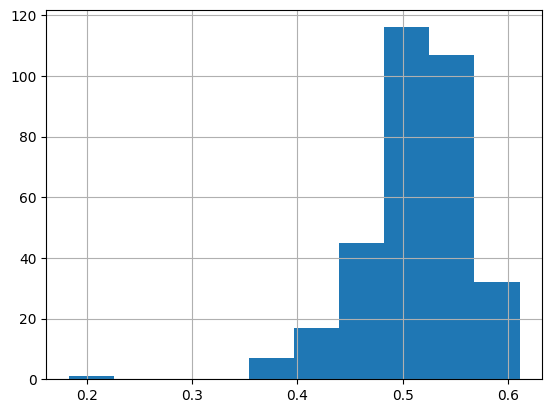

In [ ]:
import pandas as pd
acc_per_company  = ((valid_outs >= 0.4) == valid_targets).mean(0)
pd.Series(acc_per_company).hist(), acc_per_company.mean()

<Axes: >

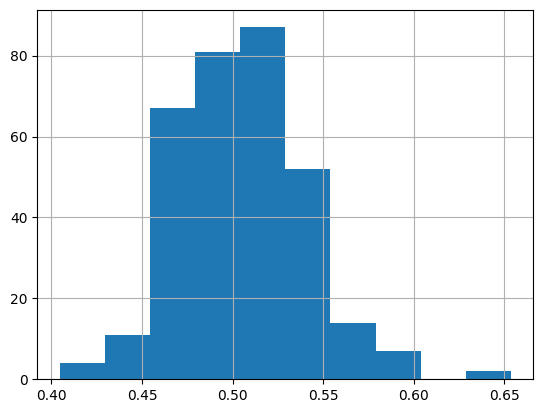

In [ ]:
import pandas as pd
acc_per_company  = ((valid_outs >= 0.5) == valid_targets).mean(0)
pd.Series(acc_per_company).hist()

In [ ]:
acc_per_company[acc_per_company.argsort()[-20:]]

array([0.56031128, 0.56031128, 0.56031128, 0.56420233, 0.56420233,
       0.56809339, 0.56809339, 0.56809339, 0.56809339, 0.57198444,
       0.57198444, 0.58365759, 0.58365759, 0.58365759, 0.58365759,
       0.59143969, 0.59533074, 0.59533074, 0.6381323 , 0.6536965 ])

In [ ]:
import pandas as pd
nasdaq_screener = pd.read_csv("/content/drive/MyDrive/Stock Market Prediction Graduation Project/nasdaq_screener.csv")
news_df = pd.read_csv("/content/drive/MyDrive/Stock Market Prediction Graduation Project/processed_news_df.csv")
news_df["mentioned_companies"] = news_df["mentioned_companies"].apply(lambda x: x[1:-1].replace("'","").replace(" ", "").split(","))
stock_df = pd.read_csv("/content/drive/MyDrive/Stock Market Prediction Graduation Project/processed_stock_df.csv")

In [ ]:
industry_to_index = {k : v for v,k in enumerate(nasdaq_screener["Sector"].unique()) }
company_to_index = {k :v for v,k in zip(range(news_df["symbol"].nunique()), news_df["symbol"].unique()) }
index_to_company = {v:k for k,v in company_to_index.items()} #reverse

<Axes: >

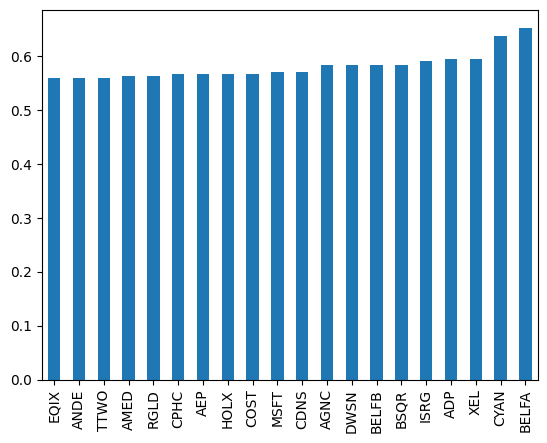

In [ ]:
best_acc_companies = [index_to_company[k] for k in acc_per_company.argsort()[-20:]]
best_acc_companies
pd.Series(data=acc_per_company[acc_per_company.argsort()[-20:]], index=best_acc_companies).plot.bar()

In [ ]:
nasdaq_screener[nasdaq_screener["Symbol"].isin(best_acc_companies)]

,Symbol,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
139,ADP,Automatic Data Processing Inc. Common Stock,$225.31,-3.68,-1.607%,9.336846e+10,United States,NaN,2328902,Consumer Discretionary,Business Services
178,AEP,American Electric Power Company Inc. Common Stock,$92.11,-2.44,-2.581%,4.733198e+10,United States,NaN,2593273,Utilities,Electric Utilities: Central
234,AGNC,AGNC Investment Corp. Common Stock,$11.96,-0.18,-1.483%,6.872216e+09,United States,2008.0,10556058,Real Estate,Real Estate Investment Trusts
405,AMED,Amedisys Inc Common Stock,$92.14,-3.92,-4.081%,2.993812e+09,United States,NaN,355776,Health Care,Medical/Nursing Services
454,ANDE,Andersons Inc. (The) Common Stock,$37.86,0.22,0.584%,1.268420e+09,United States,NaN,198554,Consumer Staples,Tobacco
926,BELFA,Bel Fuse Inc. Class A Common Stock,$40.53,-0.37,-0.905%,5.058083e+08,United States,NaN,10417,NaN,NaN
927,BELFB,Bel Fuse Inc. Class B Common Stock,$38.82,0.05,0.129%,4.844677e+08,United States,NaN,106647,NaN,NaN
1218,BSQR,BSQUARE Corporation Common Stock,$1.29,0.00,0.00%,2.643704e+07,United States,1999.0,61032,Consumer Discretionary,Business Services
1423,CDNS,Cadence Design Systems Inc. Common Stock,$185.85,-3.37,-1.781%,5.098163e+10,United States,NaN,1158901,Technology,Computer Software: Prepackaged Software
1774,COST,Costco Wholesale Corporation Common Stock,$514.80,-8.63,-1.649%,2.284317e+11,United States,NaN,1843390,Consumer Discretionary,Department/Specialty Retail Stores


In [ ]:
news_df["symbol"].value_counts()

AAPL     18777
MSFT      7574
AMZN      6136
GOOGL     4852
TSLA      4097
         ...  
CIZN         1
BELFA        1
DMLP         1
ATLO         1
CZNC         1
Name: symbol, Length: 325, dtype: int64

In [ ]:
news_df[news_df["symbol"].isin(best_acc_companies)]["symbol"].value_counts()

MSFT     7574
ADP       476
COST      465
ISRG      334
AMED      283
EQIX      212
RGLD      205
TTWO      202
XEL       188
CDNS      124
AEP        64
HOLX       61
AGNC       54
ANDE       53
BSQR        9
DWSN        7
CYAN        7
CPHC        3
BELFB       2
BELFA       1
Name: symbol, dtype: int64